<a href="https://colab.research.google.com/github/aikios/SAToxPredictions/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kora -q 
import os
import kora.install.rdkit
import pandas as pd
import sklearn
import numpy as np 
import gdown
from rdkit import Chem
from rdkit.Chem.EState import Fingerprinter
from rdkit.Chem import Descriptors, AllChem, rdMolDescriptors, MACCSkeys

from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn import metrics

import itertools
import math
import matplotlib.pyplot as plt
from scipy import stats

import pickle
import time


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Input, Flatten, Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l1,l2

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

In [ ]:
data_path1 = 'https://drive.google.com/uc?id=1R2yyQAfuhFPa3RIHOLjiMWJmC30Fn58B'
data1 = './dfwithld50vectorsnow.csv'
gdown.download(data_path1, data1, True)

df = pd.read_csv('dfwithld50vectorsnow.csv', engine = 'python', error_bad_lines=False)
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Original_SMILES', 'Name',
       'Canonical_QSARr', 'consensus_LD50', 'SMILES', 'functionalgroups',
       'Mol', 'Lipinski_NumHDonors', 'Lipinski_NumHAcceptors',
       'Lipinski_NumHeteroatoms', 'Lipinski_NumRotatableBonds',
       'Lipinski_NOCount', 'Lipinski_NHOHCount', 'Lipinski_RingCount',
       'Lipinski_HeavyAtomCount', 'NumValenceElectrons', 'NumRadicalElectrons',
       'TPSA', 'BalabanJ', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2',
       'Kappa3', 'Chi0', 'Chi1', 'Chi0v', 'Chi1v', 'Chi2v', 'Chi3v', 'Chi4v',
       'Chi0n', 'Chi1n', 'Chi2n', 'Chi3n', 'Chi4n', 'BertzCT', 'Molar_mass',
       'PEOE_VSA1', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5',
       'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'PEOE_VSA10',
       'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'SMR_VSA1',
       'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7',
       'SMR_VSA8', 'SMR_VSA9', 'SMR_VSA10', 'SlogP_VSA1', '

In [ ]:
df.head()

,Unnamed: 0,Unnamed: 0.1,Original_SMILES,Name,Canonical_QSARr,consensus_LD50,SMILES,functionalgroups,Mol,Lipinski_NumHDonors,Lipinski_NumHAcceptors,Lipinski_NumHeteroatoms,Lipinski_NumRotatableBonds,Lipinski_NOCount,Lipinski_NHOHCount,Lipinski_RingCount,Lipinski_HeavyAtomCount,NumValenceElectrons,NumRadicalElectrons,TPSA,BalabanJ,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,Chi0,Chi1,Chi0v,Chi1v,Chi2v,Chi3v,Chi4v,Chi0n,Chi1n,Chi2n,Chi3n,Chi4n,BertzCT,Molar_mass,...,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,SMR_VSA1,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SMR_VSA10,SlogP_VSA1,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,Topological,MACCS,EState,Morgan3,AtomPair,Morgan2,Torsion,LD50_mgkg,log_LD50_molkg,scaled_ld50,final,fgs,fg_vector
0,0,46902,CCCCCCCN=C(O)Oc1cc2c(cc1)N(C)[C@H]1N(C)CC[C@@]...,NaN,CCCCCCC/N=C(\O)/OC1=CC2=C(C=C1)N(C)C1N(C)CCC21C,1.561847,CCCCCCC/N=C(\O)Oc1ccc2c(c1)C1(C)CCN(C)C1N2C,"['cO/C(O)=N/C', 'cN(C)C(C)N(C)C']",<rdkit.Chem.rdchem.Mol object at 0x7f15a7a3f2b0>,1,4,5,7,5,1,3,26,144,0,48.30,1.641031,-1.75,8.195183e+05,19.023878,7.867199,3.543306,18.733840,12.469381,16.663358,9.959718,7.992175,6.019246,4.646376,16.663358,9.959718,7.992175,6.019246,4.646376,660.656317,359.514,...,5.749512,0.000000,0.000000,0.00000,6.083806,9.843390,0.0,4.89991,4.992405,63.953170,32.084767,23.762553,0.0,5.749512,11.771192,9.636773,49.440875,5.414990,0.0,57.935856,23.191506,0.0,0.000000,0.0,5.687386,5.749512,0.0,[0 0 0 0 0 0 4 0 8 0 0 3 1 0 0 1 3 0 1 0 0 0 0...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,[ 0. 0. 0. 0. ...,[0. 0. 0. ... 0. 0. 0.],[1. 1. 1. ... 0. 0. 0.],[0. 0. 0. ... 0. 0. 0.],[1. 0. 0. ... 0. 0. 0.],0.01,-7.555716,0.000000,0.000000,"[""'cO/C(O)=N/C'"", ""'cN(C)C(C)N(C)C'""]","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,8439,[Na+].[Na+].[Cu+].[O-]C(=O)CN(CC([O-])=O)CC([O...,"Cuprate(2-), [N,N-bis[(carboxy-.kappa.O)methyl...",OC(=O)CN(CC(O)=O)CC(O)=O,3.350807,O=C(O)CN(CC(=O)O)CC(=O)O,"['CC(=O)O', 'CN(C)C', 'CC(=O)O', 'CC(=O)O']",<rdkit.Chem.rdchem.Mol object at 0x7f15a881e2b0>,3,4,7,6,7,3,0,13,74,0,115.14,4.095996,-1.63,3.743475e+02,11.370000,5.093252,6.755728,10.430721,5.913591,6.634920,3.292536,2.326378,1.076602,0.741566,6.634920,3.292536,2.326378,1.076602,0.741566,187.125266,191.139,...,0.000000,0.000000,0.000000,0.00000,17.907916,29.703194,0.0,4.89991,0.000000,0.000000,19.634269,0.000000,0.0,0.000000,17.907916,0.000000,57.761677,14.383612,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,[0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 3 0 0 0 0 0 0 0...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,[ 0. 0. 0. 0. ...,[0. 0. 0. ... 0. 0. 0.],[0. 0. 0. ... 0. 0. 0.],[0. 0. 0. ... 0. 0. 0.],[0. 0. 0. ... 0. 0. 0.],0.01,-7.281349,0.039753,0.039753,"[""'CC(=O)O'"", ""'CN(C)C'"", ""'CC(=O)O'"", ""'CC(=O...","[0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,42656,C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](OC3C(=O)c4c(cc...,"2-(3,4-Bis(hydroxymethoxy)phenyl)-3-((6-O-(6-d...",CC1OC(OCC2OC(OC3C(=O)C4C(=CC(=CC=4O)OCO)OC=3C3...,3.263996,CC1OC(OCC2OC(Oc3c(-c4ccc(OCO)c(OCO)c4)oc4cc(OC...,"['cOC(C)OC', 'c=O', 'coc', 'cOCO', 'cOCO', 'cO...",<rdkit.Chem.rdchem.Mol object at 0x7f15a7bc28f0>,10,19,19,12,19,10,5,49,270,0,297.12,1.527457,-3.83,4.707463e+10,36.450582,15.375363,7.379514,35.567821,23.390687,25.635052,14.764266,11.034051,7.919291,5.341728,25.635052,14.764266,11.034051,7.919291,5.341728,1645.701314,700.599,...,65.196033,43.928125,17.468329,0.00000,0.000000,88.640466,0.0,0.00000,0.000000,68.335522,26.985709,40.555163,0.0,40.071258,10.969244,24.376242,139.462767,14.210589,0.0,6.923737,39.543523,0.0,22.292943,0.0,0.000000,28.747559,0.0,[ 0 0 0 0 0 0 1 0 4 0 0 5 10 0 0 ...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,[ 0. 0. 0. 0. ...,[0. 0. 0. ... 0. 0. 0.],[1. 1. 0. ... 0. 0. 0.],[0. 0. 0. ... 0. 0. 0.],[0. 0. 0. ... 0. 0. 0.],0.04,-7.243410,0.045250,0.045250,"[""'cOC(C)OC'"", ""'c=O'"", ""'coc'

In [ ]:
mols = []

for i in range(len(df)):
  mol = Chem.MolFromSmiles(df.Canonical_QSARr[i])
  mols.append(mol)

df['Mol'] = mols

KeyError: ignored

In [ ]:
df['Lipinski_NumHDonors'] = df['Mol'].apply(Chem.Lipinski.NumHDonors)
df['Lipinski_NumHAcceptors'] = df['Mol'].apply(Chem.Lipinski.NumHAcceptors)
df['Lipinski_NumHeteroatoms'] = df['Mol'].apply(Chem.Lipinski.NumHeteroatoms)
df['Lipinski_NumRotatableBonds'] = df['Mol'].apply(Chem.Lipinski.NumRotatableBonds)
df['Lipinski_NOCount'] = df['Mol'].apply(Chem.Lipinski.NOCount)
df['Lipinski_NHOHCount'] = df['Mol'].apply(Chem.Lipinski.NHOHCount)
df['Lipinski_RingCount'] = df['Mol'].apply(Chem.Lipinski.RingCount)
df['Lipinski_HeavyAtomCount'] = df['Mol'].apply(Chem.Lipinski.HeavyAtomCount)

ArgumentError: ignored

In [ ]:
# create descriptors
df['Molar_mass'] = df['Mol'].apply(Chem.Descriptors.MolWt)
df['NumValenceElectrons'] = df['Mol'].apply(Chem.Descriptors.NumValenceElectrons)
df['NumRadicalElectrons'] = df['Mol'].apply(Chem.Descriptors.NumRadicalElectrons)
df['TPSA'] = df['Mol'].apply(Chem.MolSurf.TPSA)

# create topological/topochemical descriptors
# http://www.rdkit.org/docs-beta/api/rdkit.Chem.GraphDescriptors-module.html
df['BalabanJ'] = df['Mol'].apply(Chem.GraphDescriptors.BalabanJ)
df['HallKierAlpha'] = df['Mol'].apply(Chem.GraphDescriptors.HallKierAlpha)
df['Ipc'] = df['Mol'].apply(Chem.GraphDescriptors.Ipc)
df['Kappa1'] = df['Mol'].apply(Chem.GraphDescriptors.Kappa1)
df['Kappa2'] = df['Mol'].apply(Chem.GraphDescriptors.Kappa2)
df['Kappa3'] = df['Mol'].apply(Chem.GraphDescriptors.Kappa3)
df['Chi0'] = df['Mol'].apply(Chem.GraphDescriptors.Chi0)
df['Chi1'] = df['Mol'].apply(Chem.GraphDescriptors.Chi1)
df['Chi0v'] = df['Mol'].apply(Chem.GraphDescriptors.Chi0v)
df['Chi1v'] = df['Mol'].apply(Chem.GraphDescriptors.Chi1v)
df['Chi2v'] = df['Mol'].apply(Chem.GraphDescriptors.Chi2v)
df['Chi3v'] = df['Mol'].apply(Chem.GraphDescriptors.Chi3v)
df['Chi4v'] = df['Mol'].apply(Chem.GraphDescriptors.Chi4v)
df['Chi0n'] = df['Mol'].apply(Chem.GraphDescriptors.Chi0n)
df['Chi1n'] = df['Mol'].apply(Chem.GraphDescriptors.Chi1n)
df['Chi2n'] = df['Mol'].apply(Chem.GraphDescriptors.Chi2n)
df['Chi3n'] = df['Mol'].apply(Chem.GraphDescriptors.Chi3n)
df['Chi4n'] = df['Mol'].apply(Chem.GraphDescriptors.Chi4n)
df['BertzCT'] = df['Mol'].apply(Chem.GraphDescriptors.BertzCT)

In [ ]:
Topologicals = []

for i in range(len(df)):
    mol = Chem.MolFromSmiles(df.Canonical_QSARr[i])
    Topologicals.append(Fingerprinter.FingerprintMol(mol)[0])

df['Topological'] = Topologicals

In [ ]:
df['MACCS'] = df['Mol'].apply(MACCSkeys.GenMACCSKeys)

In [ ]:
df.dropna( inplace=True)

X = df.drop(['scaled_ld50', 'LD50_mgkg', 'log_LD50_molkg', 'final', 'Name', 'Original_SMILES', 'Canonical_QSARr', 'SMILES', 'functionalgroups', 'MACCS', 'fgs', 'Mol', 'Topological', 'EState', 'Morgan3', 'AtomPair', 'Morgan2', 'Torsion', 'fg_vector'], axis = 1)
selected_columns = df['LD50_mgkg'] 
Y = selected_columns.copy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [ ]:
def accuracy_check(predictions, actual):
  difference_list = []
  percent_list = []
  for i,j in zip(predictions, actual): 
    difference = i - j
    difference_list.append(difference)
  for i,j in zip(difference_list,actual):
    percent = i / j * 100
    percent_list.append(percent)
  return difference_list, percent_list

In [ ]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
trainpred = regr.predict(X_train)
predictions = regr.predict(X_test) 
 
difference_list, percent_list = accuracy_check(predictions, y_test)

In [ ]:
log_y_test = []
log_y_train = []
log_trainpred = []
log_testpred = []

for i in trainpred:
  b = np.log(i)
  log_trainpred.append(b)

for i in predictions:
  b = np.log(i)
  log_testpred.append(b)

for i in y_train:
  b = np.log(i)
  log_y_train.append(b)

for i in y_test:
  b = np.log(i)
  log_y_test.append(b)

In [ ]:
print(sum(percent_list)/len(percent_list))

16849.282929667697


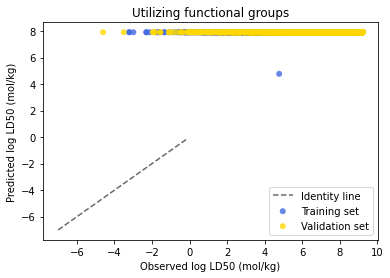

In [ ]:
plt.plot(np.arange(-7,0,0.1), np.arange(-7,0,0.1), "--",label="Identity line", c="dimgrey")
plt.scatter(log_y_train, log_trainpred, label="Training set",c="royalblue", edgecolors='none',alpha= 0.8)
plt.scatter(log_y_test, log_testpred, label="Validation set",c="gold", edgecolors='none',alpha= 0.8)
plt.xlabel("Observed log LD50 (mol/kg)")
plt.ylabel("Predicted log LD50 (mol/kg)")
plt.title("Utilizing functional groups")
plt.legend(loc="lower right")
plt.show()

In [ ]:
functional_groups_list = []
fg_list = []
df['fgs'] = ""
for index, row in df.iterrows():
    fgs = row['functionalgroups']
    q = fgs[1:-1]
    s = q.split(', ')
    row['fgs'] = s
    for i in s:
      if not functional_groups_list:
        functional_groups_list.append(i)
      else:
        b = 0
        for j in functional_groups_list:
          if i == j:
            b += 1
        if b == 0:
          functional_groups_list.append(i)
    fg_list.append(s)
df['fgs'] = fg_list        
df['fgs'].head()

1          ['CC(=O)O', 'CN(C)C', 'CC(=O)O', 'CC(=O)O']
2    ['cOC(C)OC', 'c=O', 'coc', 'cOCO', 'cOCO', 'cO...
3                                   ['cO', 'cNC(c)=O']
4                                    ['CC(C)=O', 'CO']
5                           ['CSC', 'cSC', 'Cn1cnnn1']
Name: fgs, dtype: object

In [ ]:
fg_vector_list = []
for index, row in df.iterrows():
  b = [0]*1857
  fgs = row['fgs']
  for i in functional_groups_list:
    num = functional_groups_list.index(i)
    for fg in fgs:
      if fg == i:
        b[num] += 1
  fg_vector_list.append(b)

df['fg_vector'] = fg_vector_list



In [ ]:
from keras.models import load_model

def sweep_PCA(item, epoch_size, batch_size, optim, hidden_dim, output_fxn, activation, loss_fxn):
#    m = 1 # output neurons
#    N = len(X_train) # training set size
#    hidden_dim = int(2 * math.sqrt((m + 2) * N))
    print(item,epoch_size, batch_size, optim, hidden_dim, output_fxn, activation, loss_fxn)
    model = None
    rms_test = math.sqrt(metrics.mean_squared_error(y_test, test_pred))     # hopefully rms < 0.12196980916781124    
    rms_train = math.sqrt(metrics.mean_squared_error(y_train, train_pred))
    q2 = metrics.r2_score(y_train, train_pred)
    r2 = metrics.r2_score(y_test, test_pred)
    rho = stats.spearmanr(y_test, test_pred)
    hopefully_final.append((item, epoch_size, batch_size, optim, hidden_dim,
                                      output_fxn, activation, loss_fxn, rms_test, rms_train, q2, r2,
                                      rho, y_train, train_pred, y_test, test_pred, X_train, X_test))
    try:
        X_train = np.array(list(X_train_all_fp[item])) #(list(with_LD50[item]))
        X_test = np.array(list(X_test_all_fp[item])) 
    #        except:
    #            make_2D = np.reshape(np.array(list(data[data.log_LD50_molkg.notnull()][item])), (-1,1))
    #            X = make_2D
    #    y = scaled_LD50 #log_LD50_molkg_lst

        #Scale X to unit variance and zero mean
        st = StandardScaler()
        try:
            try:
                X_train = st.fit_transform(X_train)
                X_test = st.fit_transform(X_test)
            except:
                reshape = np.reshape(X_train, (-1,1))
                X_train = st.fit_transform(reshape)
                
                reshape = np.reshape(X_test, (-1,1))
                X_test = st.fit_transform(reshape)

            # standardize?
            #these_vals = []
#            kf = model_selection.KFold(n_splits=10)
#            X = with_LD50[item]
#            try:
#                X = st.fit_transform(X)
#            except:
#                reshape = np.reshape(X, (-1,1))
#                X = st.fit_transform(reshape)       
                      
#            for train,test in kf.split(X):
#                X_train, X_test, y_train, y_test =  X[train], X[test], y[train], y[test]

            model = Sequential()
            model.add(Dense(input_dim=X_train.shape[1], units=hidden_dim))#units=5))
            #model.add(Dropout (0.2))
            model.add(Activation(activation)) #"relu"
            model.add(Dense(units=1))
            model.add(Activation(output_fxn)) #"linear"
            # add line to stop if loss is negative

            model.compile(loss=loss_fxn, optimizer=optim)#'mean_squared_error', Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))
            stop = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto')
            reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=10, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
            history = model.fit(np.array(X_train), np.array(y_train), epochs=epoch_size, batch_size=batch_size, verbose=1, callbacks=[stop, reduce_lr])

            test_pred = model.predict(X_test)
            train_pred = model.predict(X_train)
            model.save(item+'_final_LD50_feb16.h5')
            model.save_weights(item+'_final_LD50_feb16_weights.h5')
            # add constraints model.add(Dense(64, kernel_constraint=max_norm(2.)))
            #http://pubs.acs.org/doi/pdf/10.1021/acs.jcim.6b00088, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4530125/


        except:
            print('Try reshaping ' + item)
            
    except:
        duds.append((item, epoch_size, batch_size, optim, hidden_dim,
                              output_fxn, activation, loss_fxn, rms, q2, r2,
                              rho, y_train, train_pred, y_test, test_pred))

In [ ]:
import os

sweep_PCA('MACCS', 2000,43,'Adagrad',245,'sigmoid','softsign','binary_crossentropy')
sweep_PCA('rdkit_numeric_param', 2000,60,'Adadelta',245,'hard_sigmoid','softsign','mean_absolute_error')
sweep_PCA('toxprint_fp', 2000,46,'SGD',245,'hard_sigmoid','softsign','binary_crossentropy')
sweep_PCA('Topological', 2000,54, 'SGD',245,'sigmoid','softsign','mean_absolute_error')
sweep_PCA('EState', 2000,43, 'SGD',245,'hard_sigmoid','softsign','binary_crossentropy')

if osSleep:
    osSleep.uninhibit() 

MACCS 2000 43 Adagrad 245 sigmoid softsign binary_crossentropy


UnboundLocalError: ignored